In [2]:
!pip3 install pyro-ppl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 5.2 MB/s 


In [3]:
from pyro.poutine import trace
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
import torch 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [21]:
#hyperparamet
steps = 10000

In [22]:
def data_generate():
  rand = torch.randn(100)
  x = rand
  y = rand * 4 + 2
  return x, y

def linear_regression_model(x, y):
  W = pyro.param("W", torch.randn(1))
  b = pyro.param("b", torch.randn(1))
  train_y = W * x + b

  with pyro.plate("data", len(x)):
      return pyro.sample("obs", dist.Normal(train_y, 1), obs=y)
def guide(x, y):
    pyro.sample("W", dist.Normal(0., 1.))
    pyro.sample("b", dist.Normal(0., 1.))

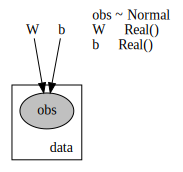

In [23]:
x,y = data_generate()
pyro.render_model(linear_regression_model, model_args=(x, y), render_distributions=True, render_params=True)

-0.012383288703858852 0.6294452548027039
0.9257522225379944 1.4867888689041138
1.749401330947876 2.0251734256744385
2.469831943511963 2.2151994705200195
3.0825014114379883 2.168294668197632
3.558795213699341 2.081036329269409
3.857199192047119 2.0259206295013428
3.9772164821624756 2.004126787185669
3.998929023742676 2.0001955032348633
3.9999804496765137 2.0000059604644775


Text(0, 0.5, 'ELBO loss')

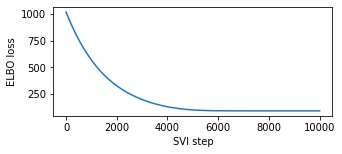

In [24]:
x,y = data_generate()

pyro.clear_param_store()
optimizer = optim.Adam({"lr": 0.001})
auto_guide = pyro.infer.autoguide.AutoNormal(linear_regression_model)
train_model = pyro.infer.SVI(linear_regression_model, auto_guide, optimizer, loss = pyro.infer.Trace_ELBO())

losses = []
for step in range(steps):
    loss = train_model.step(x,y)
    losses.append(loss)
    if step%1000==0:
        print(pyro.param("W").item(), pyro.param("b").item())

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

3.999988317489624 2.0000035762786865
tensor([[ 1.5056e+00, -1.8973e-01,  4.8313e+00,  2.8204e+00, -1.6463e+00,
          4.9007e+00,  2.9133e+00,  2.9520e+00, -1.0792e+00,  5.0663e+00,
          6.6928e+00,  8.7853e-01, -2.6230e+00,  5.8002e+00,  3.9260e+00,
          2.9221e+00, -6.6650e+00,  6.1823e+00,  4.1296e-01,  1.1070e+00,
          7.1291e+00,  2.1834e+00,  5.2215e+00, -9.0253e+00, -3.3056e+00,
         -1.4433e+00,  4.9323e+00, -8.1728e-01, -7.9605e-01,  6.2660e-01,
         -9.8873e-01,  7.3854e+00,  1.4452e+00,  6.2406e+00,  3.9470e+00,
          9.1871e-02,  5.8921e-01, -3.8058e+00, -1.4564e+00,  7.1519e+00,
          1.5183e+00,  3.8597e+00, -1.5975e+00,  2.7852e+00,  7.6431e-01,
          2.5591e+00, -3.8579e-02,  5.4375e+00,  3.4028e+00, -2.3270e+00,
          2.0782e+00,  4.8272e+00,  4.6740e+00,  3.2918e+00,  6.4223e+00,
         -1.0261e+00,  1.2134e+00, -2.1129e-01, -7.1845e-03, -1.2291e+00,
         -5.7527e+00,  8.3745e+00,  6.6307e+00,  2.5128e+00, -6.1285e-01,
 

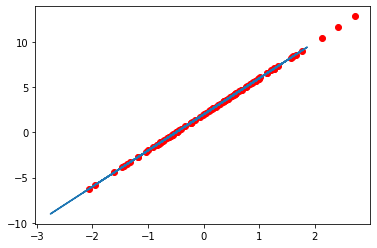

In [25]:
W = pyro.param("W").item()
b = pyro.param("b").item()

predictive = pyro.infer.Predictive(linear_regression_model, guide=auto_guide, num_samples=1)
pred_x = torch.randn(100)
pred_y = pred_x * W + b
model_pred = predictive(pred_x, pred_y)["obs"]

print(W,b)
print(model_pred)

plt.plot(x , y , 'ro', label='Original data')
plt.plot(pred_x, pred_y, label='training line')
plt.show()